In [9]:
from objVAE import vae, fg, bg_single
import numpy as np
import glob
import tifffile
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import skimage
import torch
import h5py
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


(200, 81, 128)
tensor([[[0.6816, 0.5884, 0.6099,  ..., 0.6987, 0.6460, 0.6582],
         [0.6460, 0.7114, 0.6270,  ..., 0.6201, 0.6143, 0.6768],
         [0.6611, 0.7441, 0.7075,  ..., 0.6689, 0.5840, 0.6606],
         ...,
         [0.6489, 0.6694, 0.6606,  ..., 0.4888, 0.6450, 0.6426],
         [0.6860, 0.7002, 0.7329,  ..., 0.6040, 0.6108, 0.6553],
         [0.5752, 0.6216, 0.6685,  ..., 0.5957, 0.7534, 0.6719]]])


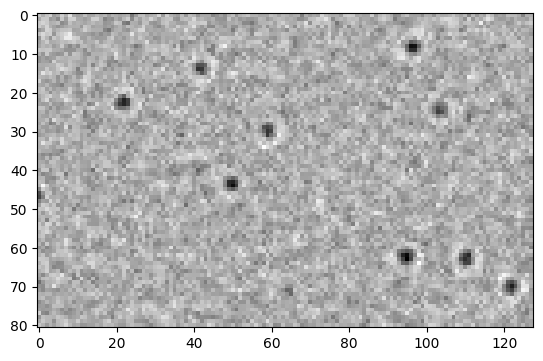

In [10]:
import tifffile

path = r'/data/mp_mpa/simulated/Sim_results_Low.tiff'

images = tifffile.imread(path, key=range(300, 500))
print(images.shape)

#images = np.split(images, 591, axis=0)
images = (images-np.min(images))/(np.max(images)-np.min(images))
training_images = torch.tensor(np.array(images), dtype=torch.float32)
training_images = torch.unsqueeze(training_images, axis=1)
print(training_images[0])
plt.imshow(np.squeeze(training_images[8,:,:,:]), cmap='gray')


In [11]:
train, test = torch.utils.data.random_split(training_images, [0.9, 0.1])
train_loader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=8, shuffle=False)

In [33]:
import matplotlib.pyplot as plt

def plot(model, test_loader):
    # forwards pass
    # model.eval()
    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    recon, presence, bg, fgs, xy, latents_fg, kl_bg, kl_fg = model(x)
    fg1, fg2 = fgs[:2]
    print(xy.shape, presence.shape)
    alpha = presence[0].detach().cpu().numpy() > 0.25
    xy = xy.detach().cpu().numpy()[0, alpha]

    plt.figure(figsize=(20, 20))
    plt.subplot(2, 2, 1)
    plt.imshow(x[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    
    plt.scatter(xy[:, 1], xy[:, 0], marker="o", s=300, edgecolor="r", facecolor="none")
    
    plt.title("Input image")
    
    plt.subplot(2, 2, 2)
    plt.imshow(
        recon[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("Reconstruction")
    
    plt.subplot(2, 2, 3)
    plt.imshow(
        fg1[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("FG 1")
    
    
    plt.subplot(2, 2, 4)
    plt.imshow(
        fg2[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("FG 2")

    return plt

bg_params = {
    'decoder_activation': 'relu',
    'decoder_channels': 60,
    'decoder_norm': 'batch',
    'decoder_depth': 6,
    'encoder_activation': 'relu',
    'encoder_channels': 36,
    'encoder_norm': 'instance',
    'encoder_depth': 5,
    'hidden_dim': 12,
    'position_dim': 128
}

fg_params = {
    'decoder_activation': 'relu',
    'decoder_feature_size': 56,
    'decoder_norm': 'none',
    'decoder_norm_first': True,
    'decoder_num_layers': 6,
    'glimpse_size': 16,
    'latent_dim': 10,
    'position_embedding': 'radial',
    'position_prediction_scale': 1,
    'position_representation_scale': 1,
    'position_embedding_dim': 1,
    'num_entities': 10,
    'encoder_depth': 3,
    'topk_select_method': "max"
}

fg_model = fg.objFG(**fg_params)
bg_model = bg_single.objBG(in_channels=1,image_size=128, **bg_params)
model = vae.objVAE(bg_model=bg_model, fg_model=fg_model, beta=1e-9, learning_rate=8e-4)

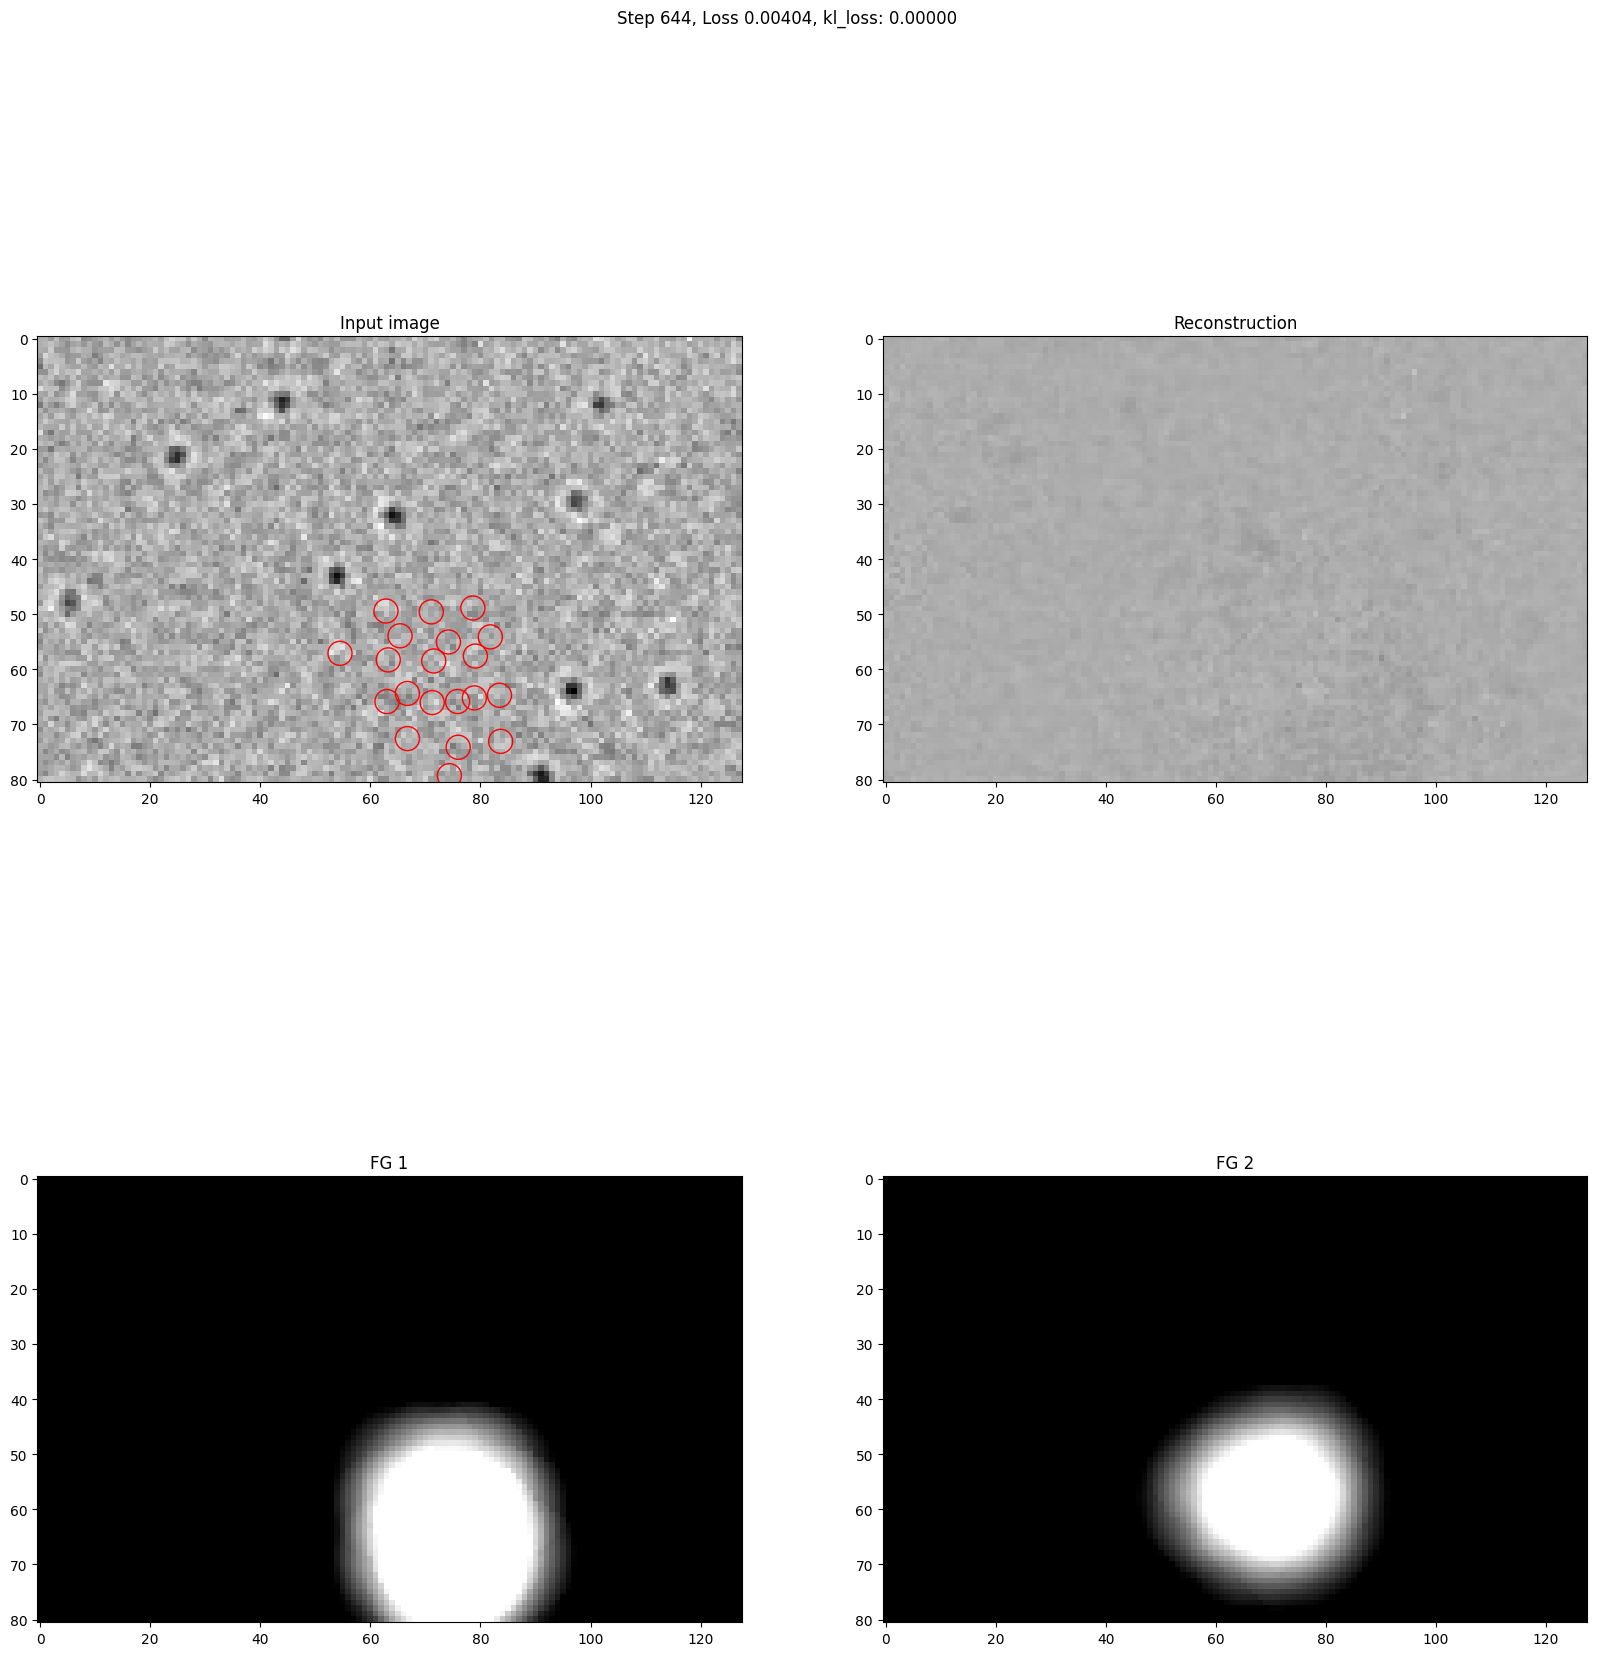

Epoch 28: 100%|██████████| 23/23 [00:00<00:00, 38.02it/s]torch.Size([1, 20, 2]) torch.Size([1, 20])


In [34]:
# anneal beta from 1e-10 to 1e-8 over 150 epochs
import numpy as np
import IPython.display as ipd
import pytorch_lightning as pl
#import optuna

max_steps = 20000

# Annealing beta (weighting of kl-term of loss) helps 
# avoid mode collapse where every parameter is unit gaussian.
beta_annealing_end = max_steps

# Annealing learning rate helps push the ELBO pareto frontier
lr_annealing_end = max_steps

# KL importance annealing makes the network sample latents based on
# residual error from background model early in training, to increase
# stability
kl_annealing_end = 2400

# Presence annealing biases the network towards saying that a latent is
# an object early in training (to avoid collapse where nothing is a object)
# and biases towards saying latents are not an object late in training
# (to avoid multiple detections of the same objects)
presence_annealing_end = 1000

class PlottingCallback(pl.Callback):


    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:

        
        loss = trainer.callback_metrics["reconstruction_epoch"]
        kl = trainer.callback_metrics["kl_epoch"]
        plot(model, train_loader)
        plt.suptitle(f"Step {trainer.global_step}, Loss {loss:.5f}, kl_loss: {kl:.5f}")
        ipd.clear_output(wait=True)
        plt.show()

        
def beta_annealing(step):
    logs = np.logspace(-0, -0, beta_annealing_end) # 8.3 - 7
    if step < beta_annealing_end:
        return 0
    else:
        return 0

def kl_annealing(step):
    logs = np.linspace(0, 1, kl_annealing_end)
    if step < kl_annealing_end*0.5:
        return 1
    if step < kl_annealing_end:
        return 1
    else:
        return 1
    
def lr_annealing(step):
    logs = np.logspace(-3, -5, lr_annealing_end)
    
    if step < lr_annealing_end:
        return logs[step]
    else:
        return logs[-1]
    
def presence_bias_annealing(step):
    lins = np.linspace(1, 0, presence_annealing_end)
    if step < presence_annealing_end:
        return lins[step]
    else:
        return 0
    
class Annealing(pl.Callback):
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        step = trainer.global_step
        
        pl_module.beta = beta_annealing(step)
        pl_module.fg_model.kl_importance = kl_annealing(step)
        pl_module.optimizers().lr = lr_annealing(step)
        pl_module.presence_bias = presence_bias_annealing(step)

trainer = pl.Trainer(
    max_steps=max_steps,
    callbacks=[PlottingCallback(), Annealing()],
    logger=False,
#     check_val_every_n_epoch=1000,
)

# model.fg_model.topk_select_method = "random"
trainer.fit(model, train_loader)

# evaluate
#test_results = trainer.test(model, test_loader)